### Qualitative visualization of what our planner does under the hood

In [1]:
%matplotlib inline
# %matplotlib notebook
import time
import math
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, animation

import sys
sys.path.insert(0, '../mppi_numba')
from mppi_numba.density import Density, GaussianMixture
from mppi_numba.terrain import Terrain, TDM_Numba, TractionGrid
from mppi_numba.visualization import TDM_Visualizer, vis_density, vis_density_as_pmf
from mppi_numba.mppi import MPPI_Numba
from mppi_numba.config import Config
import pickle


Terrain Vegetation has the following properties for linear and angular tractions.
mean=(0.51, 0.50), std=(0.35, 0.35), cvar(0.10)=(0.02, 0.02) (computed from 10000.0 saved samples)
Terrain Dirt has the following properties for linear and angular tractions.
mean=(0.65, 0.65), std=(0.10, 0.10), cvar(0.10)=(0.47, 0.48) (computed from 10000.0 saved samples)


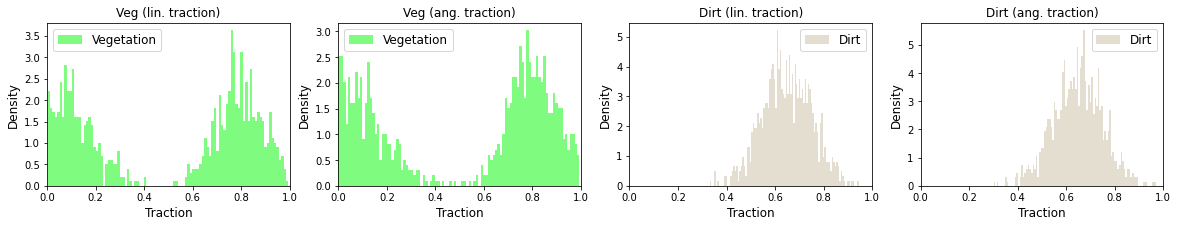

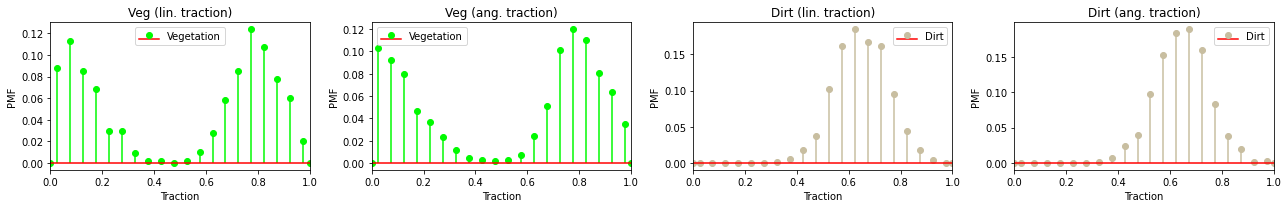

In [2]:
# What percentile of the speed distribution to compute conditional expectation?
pmf_bounds = [0, 1.0]
bush_weights = [0.6, 0.4]
bush_means= [0, 0.8]
bush_std = [0.15, 0.1]
dirt_weights = [1]
dirt_means = [0.65]
dirt_std = [0.1]
bush_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std)
bush_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std)
dirt_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std)
dirt_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std)

bush = Terrain(name='Vegetation', lin_density=bush_lin_gm, ang_density=bush_ang_gm, rgb=np.array((0,250,0))/255.0)
dirt = Terrain(name='Dirt', lin_density=dirt_lin_gm, ang_density=dirt_ang_gm, rgb=np.array((200,190,160))/255.0)
print(bush)
print(dirt)

ID2NAME = {
    0: dirt.name,
    1: bush.name
}
NAME2TERRAIN = {
    bush.name: bush,
    dirt.name: dirt
}

num_bins=20
b_lin_values, b_lin_pmf = bush_lin_gm.get_pmf(num_bins=num_bins)
b_ang_values, b_ang_pmf = bush_ang_gm.get_pmf(num_bins=num_bins)
d_lin_values, d_lin_pmf = dirt_lin_gm.get_pmf(num_bins=num_bins)
d_ang_values, d_ang_pmf = dirt_ang_gm.get_pmf(num_bins=num_bins)



LIN_TERRAIN2PMG = {
    bush: (b_lin_values, b_lin_pmf),
    dirt: (d_lin_values, d_lin_pmf),
}
ANG_TERRAIN2PMG = {
    bush: (b_ang_values, b_ang_pmf),
    dirt: (d_ang_values, d_ang_pmf),
}
# -------------- Visualize the speed distribution for each class---------
fig, axes = plt.subplots(1, 4, figsize=(20, 3))
vis_density(axes[0], bush_lin_gm, bush, title="Veg (lin. traction)", color=bush.rgb)
vis_density(axes[1], bush_ang_gm, bush, title="Veg (ang. traction)", color=bush.rgb)
vis_density(axes[2], dirt_lin_gm, dirt, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density(axes[3], dirt_ang_gm, dirt, title="Dirt (ang. traction)", color=dirt.rgb)

fig, axes = plt.subplots(1, 4, figsize=(18, 3))
vis_density_as_pmf(axes[0], bush_lin_gm, bush, num_bins=num_bins, title="Veg (lin. traction)", color=bush.rgb)
vis_density_as_pmf(axes[1], bush_ang_gm, bush, num_bins=num_bins, title="Veg (ang. traction)", color=bush.rgb)
vis_density_as_pmf(axes[2], dirt_lin_gm, dirt, num_bins=num_bins, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density_as_pmf(axes[3], dirt_ang_gm, dirt, num_bins=num_bins, title="Dirt (ang. traction)", color=dirt.rgb)

plt.tight_layout()
plt.show()

TDM has initialized GPU memory after 0.39925718307495117 s
TDM has initialized GPU memory after 0.040946006774902344 s
MPPI planner has initialized GPU memory after 0.016928434371948242 s


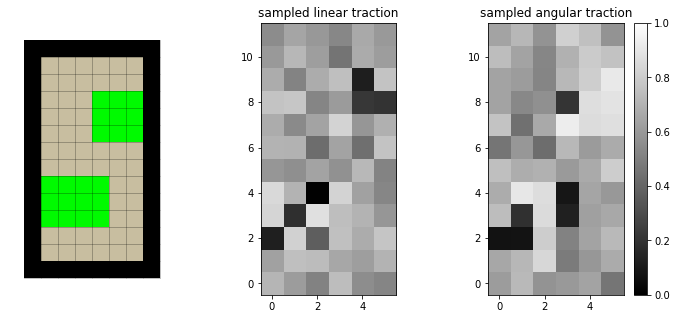

In [3]:
# ------------- Create and visualize the example map ------------
res = 1.0
semantic_grid = np.array([
  [0,0,0,0,0,0,],
  [0,0,0,0,0,0,],
  [1,1,1,1,0,0,],
  [1,1,1,1,0,0,],
  [1,1,1,1,0,0,],
  [0,0,0,0,0,0,],
  [0,0,0,0,0,0,],
  [0,0,0,1,1,1,],
  [0,0,0,1,1,1,],
  [0,0,0,1,1,1,],
  [0,0,0,0,0,0,],
  [0,0,0,0,0,0,],
])

grid_shape = semantic_grid.shape

xlimits = (0,semantic_grid.shape[1]*res)
ylimits = (0,semantic_grid.shape[0]*res)
num_pmf_bins = len(d_ang_pmf) # Assume numbers of bins are the same for linear and angular components for now
bin_values = b_lin_values
bin_values_bounds = (np.min(b_lin_values), np.max(b_lin_values))
max_speed = 3.0

# --- Choose one of the algorithms ---
use_tdm = True # Use the full traction distribution (ICRA23). Visualize the optimal control over samples of traction maps
use_det_dynamics = False # Use the cvar of traction distribution (ICRA23). Visualize multiple control samples over the worst-case traction map.
use_nom_dynamics_with_speed_map = False # Adjust time cost with worst-case speed (IROS22). Visualize multiple control samples over the worst-case traction map.
use_costmap = False # Not used in sim. Can be used to handle costmap2d from ROS.

assert use_tdm+use_det_dynamics+use_nom_dynamics_with_speed_map+use_costmap==1, "Only one of the methods can be chosen."
assert not use_costmap, "Interface with costmap2d not supported here."

# Configure the risk tolerance based on algorithm
if use_tdm:
  cvar_alpha = 0.8 # Risk tolerance for the objective
  alpha_dyn = 1.0 # Should be kept 1.0 (use full distribution), but can optionally sample from worst alpha_dyn quantile of traction distribution
elif use_det_dynamics:
  cvar_alpha = 1.0 # This param not used
  alpha_dyn = 0.1 # Use worst-case expected traction (dynamics) for rollouts.
elif use_nom_dynamics_with_speed_map:
  cvar_alpha = 1.0 # This param not used
  alpha_dyn = 0.2 # Use worst-case expected linear traction to adjust speed cost
else:
  cvar_alpha = 1.0
  alpha_dyn = 1.0

num_vis_state_rollouts = 100
if use_det_dynamics or use_nom_dynamics_with_speed_map or use_costmap:
  num_vis_state_rollouts = 1 # just visualize the best solution



# ------ General configs for both MPPI and TDM ------
cfg_kwargs = dict(
  T = 10.0,
  dt = 0.1,
  num_grid_samples =  1024,
  num_control_rollouts = 1024,
  max_speed_padding = 5.0,
  num_vis_state_rollouts = num_vis_state_rollouts,
  max_map_dim =(15, 15),
  seed = 1,
  use_tdm = use_tdm,
  use_det_dynamics = use_det_dynamics,
  use_nom_dynamics_with_speed_map = use_nom_dynamics_with_speed_map,
  use_costmap = use_costmap,
)
cfg = Config(**cfg_kwargs)

# ------------- Problem configuration ------------
x0=np.array([1, 1, 0])
xgoal= np.array([grid_shape[1]-1, grid_shape[0]-1])

mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,
    timesteps=cfg.num_steps,

    # For risk-aware min time planning
    goal_tolerance=1.0,
    v_post_rollout=0.01, # 0.01,
    cvar_alpha=cvar_alpha,
    alpha_dyn=alpha_dyn,

    # Hyper parameters
    lambda_weight=1.0,
    num_opt= 1, # how many steps in each solve() function call

    # Control and sample specification
    u_std=np.array([2.0, 2.0]), # angular part affects how much robot turns to squeeze through gaps
    vrange = np.array([0, max_speed]), 
    wrange=np.array([-np.pi, np.pi]),
)

# ------------- Configure the TDM based on whether determinisitc dynamics are used ------------
lin_tdm = TDM_Numba(cfg)
ang_tdm = TDM_Numba(cfg)
lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG,
                    mppi_params['alpha_dyn'])
ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                    xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG,
                    mppi_params['alpha_dyn'])
lin_tdm_vis = TDM_Visualizer(lin_tdm)

fig, axes = plt.subplots(ncols=3, figsize=(12,5))
ax = axes[0]
lin_tdm_vis.draw(ax=ax)
mppi_planner = MPPI_Numba(cfg)

# Sample a specific map from the distribution that can be used to update the robot state
ax = axes[1]
traction_grid = lin_tdm.sample_grids_true_dist()
lin = traction_grid.lin_traction
img = ax.imshow(lin, origin='lower', vmin=0, vmax=1.0, cmap='gray')
ax.set_title('sampled linear traction')

# fig, ax = plt.subplots()
ax = axes[2]
ang = traction_grid.ang_traction
img = ax.imshow(ang, origin='lower', vmin=0, vmax=1, cmap='gray')
ax.set_title('sampled angular traction')
plt.colorbar(img)
plt.show()

### Run planner on a sampled traction map (unknown to planners)

/home/jeremy/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/jeremy/.local/lib/python3.8/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


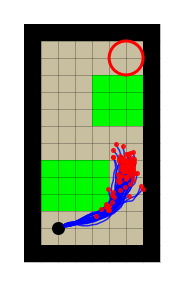

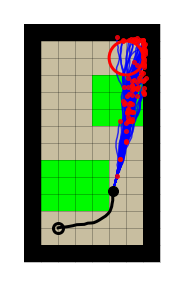

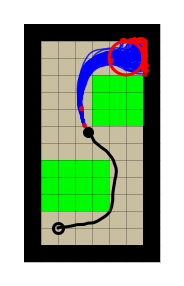

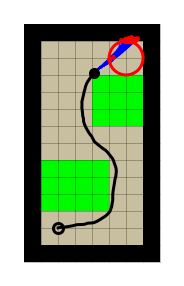

goal reached at t=10.50s


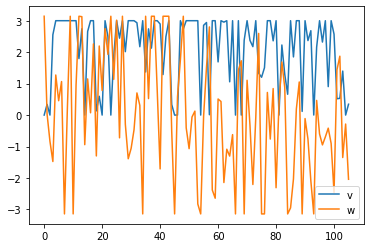

In [4]:
# Construct the MPPI planner + initialize the GPU variables
mppi_planner.setup(mppi_params, lin_tdm, ang_tdm)

# Loop
max_steps =150
# max_steps = 1
xhist = np.zeros((max_steps+1, 3))*np.nan
uhist = np.zeros((max_steps, 2))*np.nan
xhist[0] = x0

plot_every_n = 30
# plot_every_n = 1
for t in range(max_steps):
  # Solve
  useq = mppi_planner.solve()
  u_curr = useq[0]
  uhist[t] = u_curr

  # Simulate state forward using the sampled map
  lt, at = traction_grid.get(xhist[t,0], xhist[t,1])
  xhist[t+1, 0] = xhist[t, 0] + cfg.dt*lt*np.cos(xhist[t, 2])*u_curr[0]
  xhist[t+1, 1] = xhist[t, 1] + cfg.dt*lt*np.sin(xhist[t, 2])*u_curr[0]
  xhist[t+1, 2] = xhist[t, 2] + cfg.dt*at*u_curr[1]


  if t%plot_every_n==0:
    # Visualize the basic set up
    lin_tdm_vis = TDM_Visualizer(lin_tdm)
    fig, ax = lin_tdm_vis.draw(figsize=(5, 5))
    ax.plot([x0[0]], [x0[1]], 'ko', markersize=10, markeredgewidth=3, markerfacecolor='none', label="Start")
    ax.plot([xhist[t+1, 0]], [xhist[t+1, 1]], 'ko', markersize=10, label="Curr. State", zorder=5)
    # c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='r', linewidth=3, fill=False, label="Goal", zorder=6)
    c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='r', linewidth=3, fill=False, zorder=6)
    c1_dummpy = ax.plot([xgoal[0]-1e6], [xgoal[1]-1e6], 'ro', markersize=10, markeredgewidth=3, markerfacecolor='none', label="Goal", zorder=6)
    ax.add_patch(c1)

    # # Get rollout states from subset of maps for visualization? (e.g., 50)
    rollout_states_vis = mppi_planner.get_state_rollout()
    ax.plot(xhist[:,0], xhist[:,1], 'k', linewidth=3, label="Past State")
    ax.plot(rollout_states_vis[:,-1,0].T, rollout_states_vis[:,-1,1].T, 'r.', alpha=0.8, markersize=8, zorder=4)
    ax.plot(rollout_states_vis[:,:,0].T, rollout_states_vis[:,:,1].T, 'b', alpha=0.8, zorder=3)
    # For the legends
    # ax.plot([1e6], [1e6], 'b-', label="Rollouts")
    # ax.legend(ncol=5)
    plt.show()
  
  # Update MPPI state (x0, useq)
  mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)

  
  # Goal check
  if np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) <=mppi_params['goal_tolerance']:
    print("goal reached at t={:.2f}s".format(t*cfg.dt))
    break


fig, ax = plt.subplots()
ax.plot(uhist[:,0], label="v")
ax.plot(uhist[:,1], label="w")
ax.legend()
plt.show()

## Visualize the rollouts as GIF (also mark the time)

In [5]:
%matplotlib notebook

In [7]:
# Construct the MPPI planner + initialize the GPU variables
mppi_planner.setup(mppi_params, lin_tdm, ang_tdm)

# Loop
max_steps = 150 # Wait till the end of max_steps
xhist = np.zeros((max_steps+1, 3))*np.nan
uhist = np.zeros((max_steps, 2))*np.nan
xhist[0] = x0

# plot_every_n = 5
plot_every_n = 1
fontsize=15
# Visualize the basic set up
lin_tdm_vis = TDM_Visualizer(lin_tdm)
fig, ax = lin_tdm_vis.draw(figsize=(8, 8))

l_start, = ax.plot([x0[0]], [x0[1]], 'ko', markersize=10, markeredgewidth=3, markerfacecolor='none', label="Start")
l_curr, = ax.plot([x0[0]], [x0[1]], 'ko', markersize=10, label="Curr. State", zorder=5)
c1 = plt.Circle(xgoal, mppi_params['goal_tolerance'], color='r', linewidth=3, fill=False, zorder=6)
c1_dummpy = ax.plot([xgoal[0]-1e6], [xgoal[1]-1e6], 'ro', markersize=10, markeredgewidth=3, markerfacecolor='none', label="Goal", zorder=6)
ax.add_patch(c1)
l_past, = ax.plot(xhist[:,0], xhist[:,1], 'k', linewidth=3, label="Past States")
l_rollout_end, = ax.plot([x0[0]], [x0[1]], 'r.', alpha=0.8, markersize=12, zorder=4)
l_rollout_list = []
for i in range(num_vis_state_rollouts):
  l_rollout, = ax.plot([[x0[0]], [x0[0]]], [[x0[1]], [x0[1]]], 'b', lw=2, alpha=0.8, zorder=3)
  l_rollout_list.append(l_rollout)
thandle = ax.set_title("t={:.1f}s".format(0), fontsize=fontsize, x=0.5, y=0.95)
ax.plot([1e6], [1e6], 'b-', label="Predicted States\nGiven Optimal Control")

ax.legend(ncol=2, fontsize=fontsize-1,
          bbox_to_anchor=(1.15, 0.06))
reached = False

def animate(t):
  # Use this function to update the history and future rollouts
  # Goal check
  global reached
  if reached:
    return

  # Solve
  useq = mppi_planner.solve()
  u_curr = useq[0]
  uhist[t] = u_curr

  # Simulate state forward using the sampled map
  lt, at = traction_grid.get(xhist[t,0], xhist[t,1])
  xhist[t+1, 0] = xhist[t, 0] + cfg.dt*lt*np.cos(xhist[t, 2])*u_curr[0]
  xhist[t+1, 1] = xhist[t, 1] + cfg.dt*lt*np.sin(xhist[t, 2])*u_curr[0]
  xhist[t+1, 2] = xhist[t, 2] + cfg.dt*at*u_curr[1]


  if t%plot_every_n==0:
    # l_start.set_data()
    l_curr.set_data([xhist[t+1, 0]], [xhist[t+1, 1]])

    # Get rollout states from subset of maps for visualization? (e.g., 50)
    rollout_states_vis = mppi_planner.get_state_rollout()
    l_past.set_data(xhist[:,0], xhist[:,1])
    l_rollout_end.set_data(rollout_states_vis[:,-1,0].T, rollout_states_vis[:,-1,1].T)
    for l_rollout, rollout in zip(l_rollout_list, rollout_states_vis):
      l_rollout.set_data(rollout[:,0], rollout[:,1])
    # For the legends
    
    # plt.show()
    ax.set_title("t={:.1f}s".format(t*mppi_params['dt']), fontsize=fontsize,
                x=0.5, y=0.95)
  
  # Update MPPI state (x0, useq)
  mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)

  
  # Goal check
  if np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) <=mppi_params['goal_tolerance']:
    reached = True
    print("goal reached at t={}".format(t))
    return


# Animation
anim = animation.FuncAnimation(fig, animate, 
                               interval=int(mppi_params['dt']*1e3), # delay between frames in milliseconds
                               frames=max_steps)
name=""
if use_tdm:
  name = "cvar_obj_alpha={}".format(mppi_params['cvar_alpha'])
elif use_det_dynamics:
  name = "cvar_dyn_alpha={}".format(mppi_params['alpha_dyn'])

# anim.save('example_gifs/tests.gif'.format(name), savefig_kwargs={'facecolor':'w'})
plt.show()


<IPython.core.display.Javascript object>

/home/jeremy/.local/lib/python3.8/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


goal reached at t=110
